## Imports

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from bitcoin_deep_learning.call_api import ApiCall
from bitcoin_deep_learning.model import RnnDlModel, LinearRegressionBaselineModel, DummyModel, RandomForestReg, RnnDlModel_test 
from bitcoin_deep_learning.trainer import read_result, cv_train
from bitcoin_deep_learning.cross_val import get_cross_XY
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import random
import joblib
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Getting data

In [2]:
#train_df = ApiCall().get_raw_glassnode_data()
#read_local(data='train')#.drop(columns = '[%]_Bitcoin_growth_rate_on_Horizon=7')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:35<00:00,  1.30s/it]


In [14]:
ApiCall().data_to_csv(train_df, name = 'all_data.csv')

date  [AVG]_[NH]_mean_hash_rate  [+]_[NH]_Days_Till_Halving  \
0    2011-09-16               1.036434e+13                         439   
1    2011-09-17               1.161376e+13                         438   
2    2011-09-18               1.363396e+13                         437   
3    2011-09-19               1.113934e+13                         436   
4    2011-09-20               1.214578e+13                         435   
...         ...                        ...                         ...   
3823 2022-03-05               1.686245e+20                         785   
3824 2022-03-06               1.789926e+20                         784   
3825 2022-03-07               2.033926e+20                         783   
3826 2022-03-08               2.023772e+20                         782   
3827 2022-03-09               1.888209e+20                         781   

      [//]_[AV]_Stock-to-Flow_Ratio  [+]_[NH]_Circulating_Supply  \
0                          1.418819                   7282650.00   
1                          1.429329                   7289350.00   
2                          1.441211                   7297250.00   
3                          1.452215                   7303600.00   
4                          1.462380                   7310600.00   
...                             ...                          ...   
3823                  108708.531831                  18975393.75   
3824                  108870.777114                  18976212.50   
3825                  108875.720822                  18977137.50   
3826                  108943.145857                  18978062.50   
3827                  108974.601445                  18978925.00   

      [+]_[NH]_Issuance  [+]_[NH]_Number_of_Active_Addresses  \
0               5950.00                                14298   
1               6700.00                                12877   
2               7900.00                                14074   
3               6350.00                                15826   
4               7000.00                                21668   
...                 ...                                  ...   
3823             768.75                               810397   
3824             818.75                               776309   
3825             925.00                               918501   
3826             925.00                               956336   
3827             862.50                               962981   

      [+]_[NH]_Mean_Block_Interval  [+]_[NH]_Number_of_Transactions  \
0                              508                             6090   
1                              455                             5320   
2                              349                             5828   
3                              454                             6526   
4                              422                             8005   
...                            ...                              ...   
3823                           439                           225198   
3824                           543                           206985   
3825                           458                           255293   
3826                           358                           255623   
3827                           396                           272667   

      [+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance  ...  \
0                                                494042     ...   
1                                                494415     ...   
2                                                494962     ...   
3                                                495218     ...   
4                                                499994     ...   
...                                                 ...     ...   
3823                                           40364804     ...   
3824                                           40386891     ...   
3825                                           40390661     ...   
3826         

In [9]:
train_df.columns

Index(['date', '[AVG]_[NH]_mean_hash_rate', '[+]_[NH]_Days_Till_Halving',
       '[//]_[AV]_Stock-to-Flow_Ratio', '[+]_[NH]_Circulating_Supply',
       '[+]_[NH]_Issuance', '[+]_[NH]_Number_of_Active_Addresses',
       '[+]_[NH]_Mean_Block_Interval', '[+]_[NH]_Number_of_Transactions',
       '[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_100',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_1k',
       '[+]_[NH]_Number_of_Addresses_with_Balance_≥_10k',
       '[%]_[BSB]_Percent_of_Supply_Last_Active_1+_Years_Ago',
       '[//]_[BSB]_Realized_HODL_Ratio',
       '[AVG]_[BSB]_Average_Spent_Output_Lifespan_(ASOL)',
       '[//]_[BSB]_Liveliness',
       '[%]_[BSB]_Percent_Balance_on_Exchanges_-_All_

In [23]:
(train_df.shape[0] - (30*(12+3)+6)) // 30

112

In [54]:
X_train_list, Y_train_list, X_test_list,Y_test_list = get_cross_XY(train_df.iloc[7:].drop(columns="date"), data=None, verbose = 2)

The set is being split in 112 folds


In [55]:
X_test_list[0]

array([[[1.21791212e+13, 1.69000000e+02, 6.82413753e+00, ...,
         1.67937598e-03, 5.71001333e+00, 5.32633229e-02],
        [1.17976561e+13, 1.68000000e+02, 6.88685491e+00, ...,
         1.88514433e-03, 5.92034750e+00, 7.74567428e-02],
        [1.22726854e+13, 1.67000000e+02, 6.96243149e+00, ...,
         1.22779752e-03, 5.96477632e+00, 6.25586436e-02],
        ...,
        [2.16723612e+13, 8.20000000e+01, 9.13427261e+00, ...,
         2.60150198e-03, 1.10033233e+01, 8.01179159e-02],
        [1.93202780e+13, 8.10000000e+01, 9.16453612e+00, ...,
         1.67524085e-03, 1.10389950e+01, 9.62075805e-02],
        [2.05127140e+13, 8.00000000e+01, 9.17701048e+00, ...,
         3.10601613e-03, 1.10733267e+01, 7.82842133e-02]],

       [[1.17976561e+13, 1.68000000e+02, 6.88685491e+00, ...,
         1.88514433e-03, 5.92034750e+00, 7.74567428e-02],
        [1.22726854e+13, 1.67000000e+02, 6.96243149e+00, ...,
         1.22779752e-03, 5.96477632e+00, 6.25586436e-02],
        [1.20181396e+13, 

In [51]:
train_df[7:].isna().sum()

date                                                      0
[AVG]_[NH]_mean_hash_rate                                 0
[+]_[NH]_Days_Till_Halving                                0
[//]_[AV]_Stock-to-Flow_Ratio                             0
[+]_[NH]_Circulating_Supply                               0
[+]_[NH]_Issuance                                         0
[+]_[NH]_Number_of_Active_Addresses                       0
[+]_[NH]_Mean_Block_Interval                              0
[+]_[NH]_Number_of_Transactions                           0
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance      0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01          0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1           0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_1             0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_10            0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_100           0
[+]_[NH]_Number_of_Addresses_with_Balance_≥_1k            0
[+]_[NH]_Number_of_Addresses_with_Balanc

In [32]:
np.array(X_train_list).shape

(113, 263, 90, 32)

In [17]:
np.array(Y_test_list).shape

(32, 90)

In [52]:
train_df.dtypes

date                                                      datetime64[ns]
[AVG]_[NH]_mean_hash_rate                                        float64
[+]_[NH]_Days_Till_Halving                                         int64
[//]_[AV]_Stock-to-Flow_Ratio                                    float64
[+]_[NH]_Circulating_Supply                                      float64
[+]_[NH]_Issuance                                                float64
[+]_[NH]_Number_of_Active_Addresses                                int64
[+]_[NH]_Mean_Block_Interval                                       int64
[+]_[NH]_Number_of_Transactions                                    int64
[+]_[NH]_Number_of_Addresses_with_a_Non-Zero_Balance               int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.01                   int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_0.1                    int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_1                      int64
[+]_[NH]_Number_of_Addresses_with_Balance_≥_10     

## Ploting models

### Plotting prediction per folds

In [47]:
def plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, model):
    fig, axs = plt.subplots(nrows = len(X_train_list), ncols = 4, figsize = (25,200))
    scores = []
    for k in range(len(X_train_list)): #range(5):#
        X_train, y_train, X_test, y_test = X_train_list[k], Y_train_list[k], X_test_list[k], Y_test_list[k]
        #intuition too much regularization on the lasso
        model.set_model()
        y_pred = model.run(X_test, X_train, y_train)
        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        axs[k, 0].plot(y_test, label = 'test')
        axs[k, 0].plot(y_pred, color = 'r', label = 'pred')
        axs[k, 0].set_title('Fitting of y_test, y_pred')
        axs[k, 0].set_ylabel('Price growth rate 7 days')
        axs[k, 0].set_xlabel('Fold sequence length in days')
        axs[k, 0].legend(loc='upper right')
        axs[k, 1].plot(y_train, label = 'train', color = 'g')
        axs[k, 1].set_title('Evolution of the y_train')
        axs[k, 1].set_ylabel('Price growth rate 7 days')
        axs[k, 1].set_xlabel('Fold sequence length in days')
        axs[k, 1].legend(loc='upper right');
        axs[k, 2].plot(model.history.history['mae'], color = 'y', label = 'mae')
        axs[k, 2].plot(model.history.history['val_mae'], color = 'b', label = 'val_mae')
        axs[k, 2].set_title('model mae')
        axs[k, 2].set_ylabel('mae')
        axs[k, 2].set_xlabel('epoch')
        axs[k, 2].legend(['train', 'test'], loc='upper right')
        axs[k, 3].plot(model.history.history['loss'], color = 'y', label = 'mae')
        axs[k, 3].plot(model.history.history['val_loss'], color = 'b', label = 'val_mae')
        axs[k, 3].set_title('model train vs validation loss')
        axs[k, 3].set_ylabel('loss')
        axs[k, 3].set_xlabel('epoch')
        axs[k, 3].legend(['train', 'validation'], loc='upper right')
        if k == 1:
            print(model.model.summary())
        print(f'############### next fold => number {k} ########## ')
    print("Mean absolute error - mean") 
    print(np.array(scores).mean())
    print("Mean absolute error - std") 
    print(np.array(scores).std())
    

### RNN Tuning

#### Tuning RNN

2022-03-10 13:08:09.450271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/250
4/4 [==============================] - 3s 189ms/step - loss: 0.3959 - mae: 0.1871 - val_loss: 0.0820 - val_mae: 0.0966
Epoch 2/250
4/4 [==============================] - 0s 60ms/step - loss: 0.0730 - mae: 0.0922 - val_loss: 0.0726 - val_mae: 0.1015
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0540 - mae: 0.0726 - val_loss: 0.0814 - val_mae: 0.0963
Epoch 4/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0524 - mae: 0.0753 - val_loss: 0.1667 - val_mae: 0.1222
Epoch 5/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0676 - mae: 0.0787 - val_loss: 0.1482 - val_mae: 0.1102
Epoch 6/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0601 - mae: 0.0748 - val_loss: 0.1582 - val_mae: 0.1171
Epoch 7/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0528 - mae: 0.0716 - val_loss: 0.0715 - val_mae: 0.0980
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0465 - mae: 0.0

4/4 [==============================] - 3s 185ms/step - loss: 0.1522 - mae: 0.1463 - val_loss: 0.0719 - val_mae: 0.0925
Epoch 2/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0416 - mae: 0.0623 - val_loss: 0.0479 - val_mae: 0.0720
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0300 - mae: 0.0593 - val_loss: 0.0391 - val_mae: 0.0630
Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0297 - mae: 0.0594 - val_loss: 0.0447 - val_mae: 0.0689
Epoch 5/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0280 - mae: 0.0584 - val_loss: 0.0378 - val_mae: 0.0615
Epoch 6/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0293 - mae: 0.0579 - val_loss: 0.0662 - val_mae: 0.0878
Epoch 7/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0299 - mae: 0.0614 - val_loss: 0.0204 - val_mae: 0.0415
Epoch 8/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0273 - mae: 0.0594 - val_lo

4/4 [==============================] - 0s 62ms/step - loss: 0.0395 - mae: 0.0594 - val_loss: 0.0128 - val_mae: 0.0455
Epoch 9/250
4/4 [==============================] - 0s 60ms/step - loss: 0.0296 - mae: 0.0579 - val_loss: 0.0155 - val_mae: 0.0367
Epoch 10/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0408 - mae: 0.0685 - val_loss: 0.0139 - val_mae: 0.0352
Epoch 11/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0272 - mae: 0.0538 - val_loss: 0.0164 - val_mae: 0.0377
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0279 - mae: 0.0554 - val_loss: 0.0058 - val_mae: 0.0326
Epoch 13/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0289 - mae: 0.0557 - val_loss: 0.0076 - val_mae: 0.0335
Epoch 14/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0242 - mae: 0.0544 - val_loss: 0.0067 - val_mae: 0.0345
Epoch 15/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0307 - mae: 0.0565 - v

Epoch 15/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0300 - mae: 0.0548 - val_loss: 0.3420 - val_mae: 0.1787
Epoch 16/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0454 - mae: 0.0630 - val_loss: 0.0089 - val_mae: 0.0801
Epoch 17/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0396 - mae: 0.0607 - val_loss: 0.0130 - val_mae: 0.1042
############### next fold => number 6 ########## 
Epoch 1/250
4/4 [==============================] - 3s 179ms/step - loss: 0.0468 - mae: 0.0656 - val_loss: 0.0449 - val_mae: 0.1857
Epoch 2/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0310 - mae: 0.0622 - val_loss: 0.0406 - val_mae: 0.1738
Epoch 3/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0300 - mae: 0.0610 - val_loss: 0.0394 - val_mae: 0.1704
Epoch 4/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0311 - mae: 0.0608 - val_loss: 0.0385 - val_mae: 0.1679
Epoch 5/250
4/4 [===================

4/4 [==============================] - 0s 116ms/step - loss: 0.0587 - mae: 0.0691 - val_loss: 1.1386 - val_mae: 0.2735
Epoch 13/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0544 - mae: 0.0680 - val_loss: 1.1865 - val_mae: 0.2917
Epoch 14/250
4/4 [==============================] - 0s 73ms/step - loss: 0.0610 - mae: 0.0732 - val_loss: 1.1100 - val_mae: 0.2677
Epoch 15/250
4/4 [==============================] - 0s 72ms/step - loss: 0.0499 - mae: 0.0677 - val_loss: 1.1162 - val_mae: 0.2705
Epoch 16/250
4/4 [==============================] - 0s 71ms/step - loss: 0.0820 - mae: 0.0920 - val_loss: 0.9619 - val_mae: 0.2129
Epoch 17/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0559 - mae: 0.0734 - val_loss: 0.9567 - val_mae: 0.2153
Epoch 18/250
4/4 [==============================] - 0s 75ms/step - loss: 0.0550 - mae: 0.0686 - val_loss: 0.9178 - val_mae: 0.2057
Epoch 19/250
4/4 [==============================] - 0s 72ms/step - loss: 0.0491 - mae: 0.0711 -

Epoch 19/250
4/4 [==============================] - 0s 62ms/step - loss: 0.2492 - mae: 0.1338 - val_loss: 0.1307 - val_mae: 0.1141
############### next fold => number 11 ########## 
Epoch 1/250
4/4 [==============================] - 3s 184ms/step - loss: 0.5766 - mae: 0.2071 - val_loss: 0.0183 - val_mae: 0.0640
Epoch 2/250
4/4 [==============================] - 0s 64ms/step - loss: 0.3122 - mae: 0.1538 - val_loss: 0.0158 - val_mae: 0.0578
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.3479 - mae: 0.1535 - val_loss: 0.0160 - val_mae: 0.0581
Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 0.2971 - mae: 0.1432 - val_loss: 0.0204 - val_mae: 0.0677
Epoch 5/250
4/4 [==============================] - 0s 64ms/step - loss: 0.3989 - mae: 0.1548 - val_loss: 0.0148 - val_mae: 0.0541
Epoch 6/250
4/4 [==============================] - 0s 64ms/step - loss: 0.2649 - mae: 0.1431 - val_loss: 0.0614 - val_mae: 0.0750
Epoch 7/250
4/4 [====================

Epoch 31/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1788 - mae: 0.1284 - val_loss: 0.0194 - val_mae: 0.0599
Epoch 32/250
4/4 [==============================] - 0s 64ms/step - loss: 0.1711 - mae: 0.1225 - val_loss: 0.0319 - val_mae: 0.0651
Epoch 33/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1673 - mae: 0.1206 - val_loss: 0.1081 - val_mae: 0.1099
Epoch 34/250
4/4 [==============================] - 0s 62ms/step - loss: 0.2379 - mae: 0.1461 - val_loss: 0.0192 - val_mae: 0.0595
Epoch 35/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1714 - mae: 0.1241 - val_loss: 0.0193 - val_mae: 0.0596
Epoch 36/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1616 - mae: 0.1213 - val_loss: 0.0197 - val_mae: 0.0604
############### next fold => number 13 ########## 
Epoch 1/250
4/4 [==============================] - 3s 187ms/step - loss: 0.6379 - mae: 0.2254 - val_loss: 0.1192 - val_mae: 0.0950
Epoch 2/250
4/4 [===============

4/4 [==============================] - 3s 187ms/step - loss: 0.4784 - mae: 0.1583 - val_loss: 0.3366 - val_mae: 0.2596
Epoch 2/250
4/4 [==============================] - 0s 64ms/step - loss: 0.3081 - mae: 0.1295 - val_loss: 0.8610 - val_mae: 0.3114
Epoch 3/250
4/4 [==============================] - 0s 63ms/step - loss: 0.2973 - mae: 0.1312 - val_loss: 0.3334 - val_mae: 0.2548
Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 0.2793 - mae: 0.1227 - val_loss: 0.7693 - val_mae: 0.2860
Epoch 5/250
4/4 [==============================] - 0s 64ms/step - loss: 0.3378 - mae: 0.1336 - val_loss: 0.3269 - val_mae: 0.2472
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.2513 - mae: 0.1227 - val_loss: 0.8599 - val_mae: 0.3126
Epoch 7/250
4/4 [==============================] - 0s 62ms/step - loss: 0.3329 - mae: 0.1263 - val_loss: 0.3295 - val_mae: 0.2487
Epoch 8/250
4/4 [==============================] - 0s 64ms/step - loss: 0.2922 - mae: 0.1286 - val_lo

4/4 [==============================] - 0s 62ms/step - loss: 0.1871 - mae: 0.1416 - val_loss: 0.0721 - val_mae: 0.0819
Epoch 24/250
4/4 [==============================] - 0s 67ms/step - loss: 0.1112 - mae: 0.1194 - val_loss: 0.1390 - val_mae: 0.1096
Epoch 25/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0717 - mae: 0.0991 - val_loss: 0.3178 - val_mae: 0.1839
Epoch 26/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0763 - mae: 0.0997 - val_loss: 0.2557 - val_mae: 0.1582
Epoch 27/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0668 - mae: 0.0966 - val_loss: 0.0330 - val_mae: 0.0864
############### next fold => number 18 ########## 
Epoch 1/250
4/4 [==============================] - 3s 186ms/step - loss: 0.3924 - mae: 0.2343 - val_loss: 0.0410 - val_mae: 0.1030
Epoch 2/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1627 - mae: 0.1290 - val_loss: 0.2249 - val_mae: 0.1422
Epoch 3/250
4/4 [=============================

4/4 [==============================] - 0s 63ms/step - loss: 0.1653 - mae: 0.1341 - val_loss: 0.0950 - val_mae: 0.0971
Epoch 6/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1914 - mae: 0.1368 - val_loss: 0.0558 - val_mae: 0.0898
Epoch 7/250
4/4 [==============================] - 0s 64ms/step - loss: 0.1633 - mae: 0.1342 - val_loss: 0.0898 - val_mae: 0.0893
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1174 - mae: 0.1249 - val_loss: 0.1121 - val_mae: 0.1057
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0897 - mae: 0.1173 - val_loss: 0.1285 - val_mae: 0.1140
Epoch 10/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1437 - mae: 0.1290 - val_loss: 0.0856 - val_mae: 0.0920
Epoch 11/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1121 - mae: 0.1297 - val_loss: 0.1304 - val_mae: 0.1149
Epoch 12/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0785 - mae: 0.1126 - val_

Epoch 12/250
4/4 [==============================] - 0s 93ms/step - loss: 0.0855 - mae: 0.0970 - val_loss: 0.0345 - val_mae: 0.0429
Epoch 13/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1105 - mae: 0.0992 - val_loss: 0.0116 - val_mae: 0.0399
Epoch 14/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0966 - mae: 0.1013 - val_loss: 0.0360 - val_mae: 0.0442
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0829 - mae: 0.0975 - val_loss: 0.0112 - val_mae: 0.0430
Epoch 16/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0843 - mae: 0.0969 - val_loss: 0.0120 - val_mae: 0.0396
Epoch 17/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0891 - mae: 0.0971 - val_loss: 0.0113 - val_mae: 0.0435
Epoch 18/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0863 - mae: 0.0967 - val_loss: 0.0355 - val_mae: 0.0437
Epoch 19/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0838 - m

4/4 [==============================] - 0s 63ms/step - loss: 0.0397 - mae: 0.0690 - val_loss: 0.0551 - val_mae: 0.0805
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0331 - mae: 0.0665 - val_loss: 0.0499 - val_mae: 0.0800
Epoch 12/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0450 - mae: 0.0713 - val_loss: 0.0481 - val_mae: 0.0797
Epoch 13/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0402 - mae: 0.0686 - val_loss: 0.0582 - val_mae: 0.0822
Epoch 14/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0317 - mae: 0.0665 - val_loss: 0.0576 - val_mae: 0.0819
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0312 - mae: 0.0657 - val_loss: 0.0480 - val_mae: 0.0795
Epoch 16/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0402 - mae: 0.0697 - val_loss: 0.0520 - val_mae: 0.0836
Epoch 17/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0480 - mae: 0.0731 - 

Epoch 13/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0505 - mae: 0.0735 - val_loss: 0.0853 - val_mae: 0.1138
Epoch 14/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0362 - mae: 0.0649 - val_loss: 0.0828 - val_mae: 0.1107
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0342 - mae: 0.0647 - val_loss: 0.0628 - val_mae: 0.1136
Epoch 16/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0410 - mae: 0.0670 - val_loss: 0.2159 - val_mae: 0.1179
Epoch 17/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0460 - mae: 0.0657 - val_loss: 0.0857 - val_mae: 0.1141
Epoch 18/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0342 - mae: 0.0643 - val_loss: 0.2452 - val_mae: 0.1324
Epoch 19/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0423 - mae: 0.0698 - val_loss: 0.0824 - val_mae: 0.1104
Epoch 20/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0350 - m

4/4 [==============================] - 0s 61ms/step - loss: 0.0345 - mae: 0.0613 - val_loss: 0.1259 - val_mae: 0.1116
Epoch 46/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0222 - mae: 0.0574 - val_loss: 0.1432 - val_mae: 0.1375
Epoch 47/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0332 - mae: 0.0753 - val_loss: 0.1317 - val_mae: 0.1148
Epoch 48/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0232 - mae: 0.0576 - val_loss: 0.1251 - val_mae: 0.1134
Epoch 49/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0228 - mae: 0.0580 - val_loss: 0.1267 - val_mae: 0.1127
############### next fold => number 30 ########## 
Epoch 1/250
4/4 [==============================] - 3s 185ms/step - loss: 0.2337 - mae: 0.1938 - val_loss: 0.1376 - val_mae: 0.1322
Epoch 2/250
4/4 [==============================] - 0s 65ms/step - loss: 0.2545 - mae: 0.1804 - val_loss: 0.0396 - val_mae: 0.0660
Epoch 3/250
4/4 [=============================

4/4 [==============================] - 0s 64ms/step - loss: 0.0445 - mae: 0.0766 - val_loss: 0.0170 - val_mae: 0.0441
Epoch 25/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0424 - mae: 0.0737 - val_loss: 0.0206 - val_mae: 0.0487
Epoch 26/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0556 - mae: 0.0814 - val_loss: 0.0241 - val_mae: 0.0533
Epoch 27/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0639 - mae: 0.0821 - val_loss: 0.0172 - val_mae: 0.0448
Epoch 28/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0439 - mae: 0.0786 - val_loss: 0.0138 - val_mae: 0.0379
Epoch 29/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0446 - mae: 0.0757 - val_loss: 0.0149 - val_mae: 0.0395
Epoch 30/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0449 - mae: 0.0758 - val_loss: 0.0207 - val_mae: 0.0491
Epoch 31/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0401 - mae: 0.0728 - 

Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0549 - mae: 0.0701 - val_loss: 0.0281 - val_mae: 0.0530
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0553 - mae: 0.0699 - val_loss: 0.0315 - val_mae: 0.0559
Epoch 13/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0548 - mae: 0.0702 - val_loss: 0.0280 - val_mae: 0.0528
Epoch 14/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0545 - mae: 0.0700 - val_loss: 0.0318 - val_mae: 0.0563
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0562 - mae: 0.0703 - val_loss: 0.0350 - val_mae: 0.0587
Epoch 16/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0539 - mae: 0.0708 - val_loss: 0.0314 - val_mae: 0.0559
Epoch 17/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0568 - mae: 0.0703 - val_loss: 0.0282 - val_mae: 0.0530
Epoch 18/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0545 - m

4/4 [==============================] - 0s 65ms/step - loss: 0.0239 - mae: 0.0515 - val_loss: 0.0037 - val_mae: 0.0295
Epoch 5/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0201 - mae: 0.0496 - val_loss: 0.0033 - val_mae: 0.0275
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0217 - mae: 0.0508 - val_loss: 0.0141 - val_mae: 0.0340
Epoch 7/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0245 - mae: 0.0525 - val_loss: 0.0190 - val_mae: 0.0412
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0252 - mae: 0.0516 - val_loss: 0.0134 - val_mae: 0.0332
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0252 - mae: 0.0509 - val_loss: 0.0154 - val_mae: 0.0363
Epoch 10/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0240 - mae: 0.0507 - val_loss: 0.0280 - val_mae: 0.0511
Epoch 11/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0274 - mae: 0.0531 - val_l

4/4 [==============================] - 0s 63ms/step - loss: 0.0677 - mae: 0.1006 - val_loss: 0.0514 - val_mae: 0.0941
Epoch 10/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0157 - mae: 0.0447 - val_loss: 0.0796 - val_mae: 0.1011
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0154 - mae: 0.0433 - val_loss: 0.1329 - val_mae: 0.1131
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0245 - mae: 0.0512 - val_loss: 0.1536 - val_mae: 0.1240
Epoch 13/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0243 - mae: 0.0529 - val_loss: 0.0494 - val_mae: 0.0915
Epoch 14/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0189 - mae: 0.0478 - val_loss: 0.1299 - val_mae: 0.1116
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0321 - mae: 0.0572 - val_loss: 0.2219 - val_mae: 0.1559
Epoch 16/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0476 - mae: 0.0829 - 

4/4 [==============================] - 0s 65ms/step - loss: 0.0388 - mae: 0.0642 - val_loss: 0.0220 - val_mae: 0.0554
Epoch 4/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0437 - mae: 0.0669 - val_loss: 0.0128 - val_mae: 0.0382
Epoch 5/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0328 - mae: 0.0624 - val_loss: 0.0124 - val_mae: 0.0374
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0329 - mae: 0.0619 - val_loss: 0.0132 - val_mae: 0.0367
Epoch 7/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0337 - mae: 0.0621 - val_loss: 0.0142 - val_mae: 0.0355
Epoch 8/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0411 - mae: 0.0672 - val_loss: 0.0284 - val_mae: 0.0634
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0435 - mae: 0.0648 - val_loss: 0.0120 - val_mae: 0.0359
Epoch 10/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0511 - mae: 0.0691 - val_lo

Epoch 66/250
4/4 [==============================] - 0s 67ms/step - loss: 0.0300 - mae: 0.0624 - val_loss: 0.0140 - val_mae: 0.0415
Epoch 67/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0131 - mae: 0.0476 - val_loss: 0.0270 - val_mae: 0.0623
Epoch 68/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0185 - mae: 0.0508 - val_loss: 0.0056 - val_mae: 0.0304
Epoch 69/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0135 - mae: 0.0477 - val_loss: 0.0394 - val_mae: 0.0779
Epoch 70/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0233 - mae: 0.0528 - val_loss: 0.0108 - val_mae: 0.0360
Epoch 71/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0139 - mae: 0.0491 - val_loss: 0.0119 - val_mae: 0.0397
Epoch 72/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0167 - mae: 0.0552 - val_loss: 0.0115 - val_mae: 0.0376
Epoch 73/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0126 - m

Epoch 15/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0208 - mae: 0.0517 - val_loss: 0.0027 - val_mae: 0.0181
Epoch 16/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0221 - mae: 0.0516 - val_loss: 0.0053 - val_mae: 0.0333
Epoch 17/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0254 - mae: 0.0531 - val_loss: 0.0080 - val_mae: 0.0261
Epoch 18/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0248 - mae: 0.0529 - val_loss: 0.0124 - val_mae: 0.0345
Epoch 19/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0218 - mae: 0.0532 - val_loss: 0.0023 - val_mae: 0.0180
Epoch 20/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0238 - mae: 0.0547 - val_loss: 0.0042 - val_mae: 0.0297
Epoch 21/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0219 - mae: 0.0520 - val_loss: 0.0028 - val_mae: 0.0216
Epoch 22/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0200 - m

Epoch 28/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0287 - mae: 0.0516 - val_loss: 0.0344 - val_mae: 0.0758
Epoch 29/250
4/4 [==============================] - 0s 60ms/step - loss: 0.0305 - mae: 0.0558 - val_loss: 0.1119 - val_mae: 0.1011
Epoch 30/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0275 - mae: 0.0524 - val_loss: 0.0955 - val_mae: 0.0903
Epoch 31/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0197 - mae: 0.0478 - val_loss: 0.0387 - val_mae: 0.0812
Epoch 32/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0215 - mae: 0.0471 - val_loss: 0.1040 - val_mae: 0.0959
Epoch 33/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0328 - mae: 0.0513 - val_loss: 0.0972 - val_mae: 0.0921
Epoch 34/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0321 - mae: 0.0558 - val_loss: 0.0435 - val_mae: 0.0874
Epoch 35/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0215 - m

4/4 [==============================] - 0s 67ms/step - loss: 0.0264 - mae: 0.0529 - val_loss: 0.0047 - val_mae: 0.0277
Epoch 6/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0222 - mae: 0.0474 - val_loss: 0.0126 - val_mae: 0.0356
Epoch 7/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0350 - mae: 0.0522 - val_loss: 0.0039 - val_mae: 0.0240
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0228 - mae: 0.0466 - val_loss: 0.0038 - val_mae: 0.0231
Epoch 9/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0221 - mae: 0.0469 - val_loss: 0.0219 - val_mae: 0.0518
Epoch 10/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0201 - mae: 0.0462 - val_loss: 0.0071 - val_mae: 0.0238
Epoch 11/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0231 - mae: 0.0480 - val_loss: 0.0038 - val_mae: 0.0229
Epoch 12/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0226 - mae: 0.0470 - val_

4/4 [==============================] - 0s 64ms/step - loss: 0.0191 - mae: 0.0410 - val_loss: 0.0029 - val_mae: 0.0250
Epoch 22/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0328 - mae: 0.0630 - val_loss: 0.0223 - val_mae: 0.0417
Epoch 23/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0198 - mae: 0.0442 - val_loss: 0.0032 - val_mae: 0.0258
Epoch 24/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0200 - mae: 0.0432 - val_loss: 0.0028 - val_mae: 0.0253
Epoch 25/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0199 - mae: 0.0442 - val_loss: 0.0037 - val_mae: 0.0276
Epoch 26/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0189 - mae: 0.0427 - val_loss: 0.0034 - val_mae: 0.0265
Epoch 27/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0160 - mae: 0.0410 - val_loss: 0.0613 - val_mae: 0.0799
Epoch 28/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0365 - mae: 0.0540 - 

4/4 [==============================] - 0s 66ms/step - loss: 0.0208 - mae: 0.0442 - val_loss: 0.0366 - val_mae: 0.0654
Epoch 6/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0211 - mae: 0.0457 - val_loss: 0.0365 - val_mae: 0.0654
Epoch 7/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0204 - mae: 0.0458 - val_loss: 0.0363 - val_mae: 0.0670
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0215 - mae: 0.0446 - val_loss: 0.0363 - val_mae: 0.0662
Epoch 9/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0209 - mae: 0.0449 - val_loss: 0.0363 - val_mae: 0.0669
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0214 - mae: 0.0447 - val_loss: 0.0363 - val_mae: 0.0665
Epoch 11/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0215 - mae: 0.0456 - val_loss: 0.0720 - val_mae: 0.0701
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0221 - mae: 0.0445 - val_

Epoch 6/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0184 - mae: 0.0419 - val_loss: 0.0163 - val_mae: 0.0562
Epoch 7/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0190 - mae: 0.0423 - val_loss: 0.0181 - val_mae: 0.0586
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0180 - mae: 0.0422 - val_loss: 0.0162 - val_mae: 0.0561
Epoch 9/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0182 - mae: 0.0418 - val_loss: 0.0181 - val_mae: 0.0585
Epoch 10/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0185 - mae: 0.0423 - val_loss: 0.0166 - val_mae: 0.0566
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0186 - mae: 0.0416 - val_loss: 0.0414 - val_mae: 0.0640
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0243 - mae: 0.0456 - val_loss: 0.0147 - val_mae: 0.0520
Epoch 13/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0257 - mae: 

4/4 [==============================] - 0s 62ms/step - loss: 0.0154 - mae: 0.0426 - val_loss: 0.0481 - val_mae: 0.0798
Epoch 53/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0103 - mae: 0.0382 - val_loss: 0.0417 - val_mae: 0.0855
Epoch 54/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0110 - mae: 0.0396 - val_loss: 0.0469 - val_mae: 0.0759
Epoch 55/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0072 - mae: 0.0359 - val_loss: 0.0393 - val_mae: 0.0722
############### next fold => number 56 ########## 
Epoch 1/250
4/4 [==============================] - 3s 195ms/step - loss: 0.0340 - mae: 0.0568 - val_loss: 0.0984 - val_mae: 0.1767
Epoch 2/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0948 - mae: 0.1117 - val_loss: 0.0103 - val_mae: 0.0502
Epoch 3/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0242 - mae: 0.0531 - val_loss: 0.0917 - val_mae: 0.0912
Epoch 4/250
4/4 [==============================

4/4 [==============================] - 0s 64ms/step - loss: 0.0220 - mae: 0.0577 - val_loss: 0.0963 - val_mae: 0.1142
Epoch 26/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0223 - mae: 0.0622 - val_loss: 0.0916 - val_mae: 0.1110
Epoch 27/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0217 - mae: 0.0588 - val_loss: 0.1265 - val_mae: 0.1299
Epoch 28/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0286 - mae: 0.0697 - val_loss: 0.0784 - val_mae: 0.1009
############### next fold => number 59 ########## 
Epoch 1/250
4/4 [==============================] - 3s 206ms/step - loss: 0.1306 - mae: 0.1232 - val_loss: 0.0798 - val_mae: 0.1027
Epoch 2/250
4/4 [==============================] - 0s 88ms/step - loss: 0.0325 - mae: 0.0724 - val_loss: 0.0815 - val_mae: 0.1058
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0329 - mae: 0.0715 - val_loss: 0.0805 - val_mae: 0.1044
Epoch 4/250
4/4 [==============================

Epoch 24/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0475 - mae: 0.0835 - val_loss: 0.0457 - val_mae: 0.0909
Epoch 25/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0469 - mae: 0.0835 - val_loss: 0.0469 - val_mae: 0.0922
Epoch 26/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0483 - mae: 0.0843 - val_loss: 0.0465 - val_mae: 0.0918
Epoch 27/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0463 - mae: 0.0841 - val_loss: 0.0441 - val_mae: 0.0891
Epoch 28/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0478 - mae: 0.0831 - val_loss: 0.0487 - val_mae: 0.0939
Epoch 29/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0481 - mae: 0.0842 - val_loss: 0.0464 - val_mae: 0.0916
Epoch 30/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0480 - mae: 0.0840 - val_loss: 0.0484 - val_mae: 0.0936
Epoch 31/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0475 - m

4/4 [==============================] - 0s 63ms/step - loss: 0.0463 - mae: 0.0866 - val_loss: 0.0583 - val_mae: 0.1245
Epoch 10/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0457 - mae: 0.0860 - val_loss: 0.0503 - val_mae: 0.1156
Epoch 11/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0498 - mae: 0.0883 - val_loss: 0.0511 - val_mae: 0.1174
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0422 - mae: 0.0828 - val_loss: 0.0431 - val_mae: 0.1066
Epoch 13/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0452 - mae: 0.0849 - val_loss: 0.0547 - val_mae: 0.1212
Epoch 14/250
4/4 [==============================] - 0s 67ms/step - loss: 0.0415 - mae: 0.0834 - val_loss: 0.0438 - val_mae: 0.1072
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0439 - mae: 0.0825 - val_loss: 0.0449 - val_mae: 0.1049
Epoch 16/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0540 - mae: 0.0877 - 

4/4 [==============================] - 0s 63ms/step - loss: 0.0443 - mae: 0.0863 - val_loss: 0.1320 - val_mae: 0.1493
Epoch 34/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0316 - mae: 0.0796 - val_loss: 0.2647 - val_mae: 0.1748
Epoch 35/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0819 - mae: 0.0987 - val_loss: 0.1089 - val_mae: 0.1324
Epoch 36/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0445 - mae: 0.0806 - val_loss: 0.0945 - val_mae: 0.1451
Epoch 37/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0383 - mae: 0.0810 - val_loss: 0.1086 - val_mae: 0.1307
Epoch 38/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0271 - mae: 0.0756 - val_loss: 0.1064 - val_mae: 0.1300
Epoch 39/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0297 - mae: 0.0751 - val_loss: 0.1107 - val_mae: 0.1338
Epoch 40/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0250 - mae: 0.0736 - 

Epoch 7/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0872 - mae: 0.1104 - val_loss: 0.1482 - val_mae: 0.1450
Epoch 8/250
4/4 [==============================] - 0s 69ms/step - loss: 0.1143 - mae: 0.1160 - val_loss: 0.3308 - val_mae: 0.1799
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0932 - mae: 0.1134 - val_loss: 0.3245 - val_mae: 0.1781
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0891 - mae: 0.1111 - val_loss: 0.2523 - val_mae: 0.1549
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0811 - mae: 0.1064 - val_loss: 0.2501 - val_mae: 0.1540
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1036 - mae: 0.1138 - val_loss: 0.2412 - val_mae: 0.1509
Epoch 13/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0895 - mae: 0.1110 - val_loss: 0.1496 - val_mae: 0.1451
Epoch 14/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1069 - mae:

4/4 [==============================] - 3s 188ms/step - loss: 0.1645 - mae: 0.1404 - val_loss: 0.0539 - val_mae: 0.0897
Epoch 2/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1691 - mae: 0.1465 - val_loss: 0.0873 - val_mae: 0.0943
Epoch 3/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1584 - mae: 0.1303 - val_loss: 0.0868 - val_mae: 0.0936
Epoch 4/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1558 - mae: 0.1294 - val_loss: 0.0531 - val_mae: 0.0882
Epoch 5/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1343 - mae: 0.1284 - val_loss: 0.0532 - val_mae: 0.0906
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1121 - mae: 0.1272 - val_loss: 0.0861 - val_mae: 0.0923
Epoch 7/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0943 - mae: 0.1254 - val_loss: 0.0946 - val_mae: 0.1005
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0956 - mae: 0.1234 - val_lo

4/4 [==============================] - 0s 63ms/step - loss: 0.1017 - mae: 0.1249 - val_loss: 0.0302 - val_mae: 0.0671
Epoch 26/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0880 - mae: 0.1158 - val_loss: 0.0332 - val_mae: 0.0688
Epoch 27/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1051 - mae: 0.1247 - val_loss: 0.0387 - val_mae: 0.0781
Epoch 28/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0961 - mae: 0.1200 - val_loss: 0.0312 - val_mae: 0.0701
Epoch 29/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0865 - mae: 0.1163 - val_loss: 0.0296 - val_mae: 0.0677
Epoch 30/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0893 - mae: 0.1161 - val_loss: 0.0304 - val_mae: 0.0665
Epoch 31/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0844 - mae: 0.1139 - val_loss: 0.0303 - val_mae: 0.0664
Epoch 32/250
4/4 [==============================] - 0s 64ms/step - loss: 0.1036 - mae: 0.1206 - 

4/4 [==============================] - 3s 189ms/step - loss: 0.2707 - mae: 0.1706 - val_loss: 0.0585 - val_mae: 0.0884
Epoch 2/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1229 - mae: 0.1248 - val_loss: 0.0653 - val_mae: 0.0916
Epoch 3/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1298 - mae: 0.1267 - val_loss: 0.0626 - val_mae: 0.0906
Epoch 4/250
4/4 [==============================] - 0s 66ms/step - loss: 0.1309 - mae: 0.1261 - val_loss: 0.0613 - val_mae: 0.0901
Epoch 5/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1278 - mae: 0.1254 - val_loss: 0.0626 - val_mae: 0.0906
Epoch 6/250
4/4 [==============================] - 0s 66ms/step - loss: 0.1340 - mae: 0.1260 - val_loss: 0.0591 - val_mae: 0.0891
Epoch 7/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1311 - mae: 0.1263 - val_loss: 0.0593 - val_mae: 0.0892
Epoch 8/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1289 - mae: 0.1260 - val_lo

Epoch 11/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0654 - mae: 0.0908 - val_loss: 0.0066 - val_mae: 0.0302
Epoch 12/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0496 - mae: 0.0890 - val_loss: 0.0321 - val_mae: 0.0737
Epoch 13/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0583 - mae: 0.0879 - val_loss: 0.0027 - val_mae: 0.0187
Epoch 14/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0535 - mae: 0.0889 - val_loss: 0.0036 - val_mae: 0.0205
Epoch 15/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0610 - mae: 0.0884 - val_loss: 0.0033 - val_mae: 0.0193
Epoch 16/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0491 - mae: 0.0858 - val_loss: 0.0050 - val_mae: 0.0246
Epoch 17/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0670 - mae: 0.0892 - val_loss: 0.0508 - val_mae: 0.0943
Epoch 18/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0729 - m

Epoch 5/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0372 - mae: 0.0632 - val_loss: 0.2103 - val_mae: 0.1368
Epoch 6/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0317 - mae: 0.0617 - val_loss: 0.1903 - val_mae: 0.1304
Epoch 7/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0314 - mae: 0.0608 - val_loss: 0.1124 - val_mae: 0.1251
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0406 - mae: 0.0659 - val_loss: 0.1224 - val_mae: 0.1288
Epoch 9/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0350 - mae: 0.0618 - val_loss: 0.1220 - val_mae: 0.1286
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0348 - mae: 0.0618 - val_loss: 0.1203 - val_mae: 0.1280
Epoch 11/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0354 - mae: 0.0622 - val_loss: 0.1190 - val_mae: 0.1274
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0348 - mae: 0

Epoch 31/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0517 - mae: 0.0749 - val_loss: 0.0116 - val_mae: 0.0369
Epoch 32/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0466 - mae: 0.0749 - val_loss: 0.0150 - val_mae: 0.0381
Epoch 33/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0385 - mae: 0.0704 - val_loss: 0.0406 - val_mae: 0.0797
Epoch 34/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0746 - mae: 0.0881 - val_loss: 0.0096 - val_mae: 0.0378
Epoch 35/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0648 - mae: 0.0756 - val_loss: 0.0116 - val_mae: 0.0375
Epoch 36/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0591 - mae: 0.0748 - val_loss: 0.0116 - val_mae: 0.0372
Epoch 37/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0563 - mae: 0.0754 - val_loss: 0.0118 - val_mae: 0.0374
Epoch 38/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0541 - m

4/4 [==============================] - 0s 62ms/step - loss: 0.0408 - mae: 0.0587 - val_loss: 0.0281 - val_mae: 0.0666
Epoch 9/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0609 - mae: 0.0715 - val_loss: 0.0469 - val_mae: 0.0768
Epoch 10/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0401 - mae: 0.0620 - val_loss: 0.0307 - val_mae: 0.0693
Epoch 11/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0369 - mae: 0.0613 - val_loss: 0.0276 - val_mae: 0.0652
Epoch 12/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0368 - mae: 0.0617 - val_loss: 0.0827 - val_mae: 0.0807
Epoch 13/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0480 - mae: 0.0651 - val_loss: 0.0312 - val_mae: 0.0696
Epoch 14/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0381 - mae: 0.0622 - val_loss: 0.0268 - val_mae: 0.0649
Epoch 15/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0397 - mae: 0.0644 - v

4/4 [==============================] - 0s 62ms/step - loss: 0.0261 - mae: 0.0550 - val_loss: 0.0436 - val_mae: 0.0881
Epoch 36/250
4/4 [==============================] - 0s 79ms/step - loss: 0.0221 - mae: 0.0548 - val_loss: 0.0495 - val_mae: 0.0957
Epoch 37/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0352 - mae: 0.0603 - val_loss: 0.0491 - val_mae: 0.0920
Epoch 38/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0337 - mae: 0.0608 - val_loss: 0.0427 - val_mae: 0.0877
Epoch 39/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0216 - mae: 0.0532 - val_loss: 0.0400 - val_mae: 0.0850
Epoch 40/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0259 - mae: 0.0612 - val_loss: 0.0465 - val_mae: 0.0924
Epoch 41/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0238 - mae: 0.0565 - val_loss: 0.0400 - val_mae: 0.0846
Epoch 42/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0193 - mae: 0.0523 - 

4/4 [==============================] - 0s 61ms/step - loss: 0.0433 - mae: 0.0720 - val_loss: 0.0651 - val_mae: 0.1004
Epoch 33/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0297 - mae: 0.0637 - val_loss: 0.0623 - val_mae: 0.0972
Epoch 34/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0283 - mae: 0.0629 - val_loss: 0.4872 - val_mae: 0.2505
Epoch 35/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0999 - mae: 0.1054 - val_loss: 0.0627 - val_mae: 0.0975
Epoch 36/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0308 - mae: 0.0635 - val_loss: 0.0549 - val_mae: 0.0945
Epoch 37/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0315 - mae: 0.0658 - val_loss: 0.0614 - val_mae: 0.0958
Epoch 38/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0310 - mae: 0.0675 - val_loss: 0.0618 - val_mae: 0.0967
Epoch 39/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0319 - mae: 0.0681 - 

4/4 [==============================] - 0s 63ms/step - loss: 0.0278 - mae: 0.0634 - val_loss: 0.1547 - val_mae: 0.1291
############### next fold => number 85 ########## 
Epoch 1/250
4/4 [==============================] - 3s 200ms/step - loss: 0.0764 - mae: 0.0914 - val_loss: 0.0805 - val_mae: 0.0704
Epoch 2/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0478 - mae: 0.0817 - val_loss: 0.1143 - val_mae: 0.0931
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0353 - mae: 0.0687 - val_loss: 0.0999 - val_mae: 0.0842
Epoch 4/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0339 - mae: 0.0681 - val_loss: 0.1024 - val_mae: 0.0858
Epoch 5/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0352 - mae: 0.0681 - val_loss: 0.1000 - val_mae: 0.0843
Epoch 6/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0350 - mae: 0.0680 - val_loss: 0.0991 - val_mae: 0.0837
Epoch 7/250
4/4 [==============================] -

Epoch 46/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0281 - mae: 0.0666 - val_loss: 0.0803 - val_mae: 0.0835
Epoch 47/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0246 - mae: 0.0637 - val_loss: 0.0919 - val_mae: 0.0906
Epoch 48/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0277 - mae: 0.0677 - val_loss: 0.1825 - val_mae: 0.1408
Epoch 49/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0319 - mae: 0.0734 - val_loss: 0.0308 - val_mae: 0.0651
Epoch 50/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0282 - mae: 0.0654 - val_loss: 0.0353 - val_mae: 0.0682
Epoch 51/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0298 - mae: 0.0668 - val_loss: 0.0310 - val_mae: 0.0648
Epoch 52/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0253 - mae: 0.0647 - val_loss: 0.0881 - val_mae: 0.0876
Epoch 53/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0311 - m

Epoch 7/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0557 - mae: 0.0781 - val_loss: 0.0434 - val_mae: 0.0568
Epoch 8/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0542 - mae: 0.0781 - val_loss: 0.0442 - val_mae: 0.0575
Epoch 9/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0557 - mae: 0.0782 - val_loss: 0.0458 - val_mae: 0.0590
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0550 - mae: 0.0784 - val_loss: 0.0445 - val_mae: 0.0578
Epoch 11/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0562 - mae: 0.0782 - val_loss: 0.0446 - val_mae: 0.0578
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0562 - mae: 0.0786 - val_loss: 0.0432 - val_mae: 0.0565
Epoch 13/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0559 - mae: 0.0780 - val_loss: 0.0489 - val_mae: 0.0619
Epoch 14/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0557 - mae:

Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0471 - mae: 0.0700 - val_loss: 0.0375 - val_mae: 0.0664
Epoch 5/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0561 - mae: 0.0740 - val_loss: 0.0411 - val_mae: 0.0702
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0430 - mae: 0.0699 - val_loss: 0.0498 - val_mae: 0.0778
Epoch 7/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0432 - mae: 0.0713 - val_loss: 0.0131 - val_mae: 0.0603
Epoch 8/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0375 - mae: 0.0687 - val_loss: 0.0233 - val_mae: 0.0566
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0510 - mae: 0.0733 - val_loss: 0.0120 - val_mae: 0.0598
Epoch 10/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0422 - mae: 0.0694 - val_loss: 0.0458 - val_mae: 0.0743
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0331 - mae: 0.

Epoch 7/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0234 - mae: 0.0550 - val_loss: 0.2493 - val_mae: 0.1464
Epoch 8/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0201 - mae: 0.0540 - val_loss: 0.2468 - val_mae: 0.1461
Epoch 9/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0339 - mae: 0.0606 - val_loss: 0.4209 - val_mae: 0.1621
Epoch 10/250
4/4 [==============================] - 0s 74ms/step - loss: 0.0402 - mae: 0.0683 - val_loss: 0.2542 - val_mae: 0.1457
Epoch 11/250
4/4 [==============================] - 0s 67ms/step - loss: 0.0273 - mae: 0.0559 - val_loss: 0.4310 - val_mae: 0.1535
Epoch 12/250
4/4 [==============================] - 0s 68ms/step - loss: 0.0228 - mae: 0.0542 - val_loss: 0.2410 - val_mae: 0.1459
Epoch 13/250
4/4 [==============================] - 0s 70ms/step - loss: 0.0324 - mae: 0.0609 - val_loss: 0.4250 - val_mae: 0.1560
Epoch 14/250
4/4 [==============================] - 0s 72ms/step - loss: 0.0275 - mae:

4/4 [==============================] - 0s 63ms/step - loss: 0.0855 - mae: 0.0838 - val_loss: 0.0258 - val_mae: 0.0669
Epoch 40/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1033 - mae: 0.0860 - val_loss: 0.0166 - val_mae: 0.0614
Epoch 41/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0616 - mae: 0.0751 - val_loss: 0.0376 - val_mae: 0.0768
Epoch 42/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0630 - mae: 0.0756 - val_loss: 0.0491 - val_mae: 0.0846
Epoch 43/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0686 - mae: 0.0785 - val_loss: 0.2702 - val_mae: 0.1841
Epoch 44/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0716 - mae: 0.0849 - val_loss: 0.0241 - val_mae: 0.0681
Epoch 45/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0500 - mae: 0.0709 - val_loss: 0.1053 - val_mae: 0.1231
Epoch 46/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1038 - mae: 0.0951 - 

4/4 [==============================] - 0s 64ms/step - loss: 0.1626 - mae: 0.1203 - val_loss: 0.0121 - val_mae: 0.0428
Epoch 6/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0895 - mae: 0.0757 - val_loss: 0.0544 - val_mae: 0.0709
Epoch 7/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0997 - mae: 0.0784 - val_loss: 0.0199 - val_mae: 0.0642
Epoch 8/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0993 - mae: 0.0801 - val_loss: 0.1240 - val_mae: 0.1225
Epoch 9/250
4/4 [==============================] - 0s 65ms/step - loss: 0.1114 - mae: 0.0912 - val_loss: 0.1275 - val_mae: 0.1236
Epoch 10/250
4/4 [==============================] - 0s 64ms/step - loss: 0.2432 - mae: 0.1645 - val_loss: 0.0406 - val_mae: 0.0626
Epoch 11/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0965 - mae: 0.0761 - val_loss: 0.1199 - val_mae: 0.1244
Epoch 12/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1052 - mae: 0.0955 - val_

4/4 [==============================] - 0s 63ms/step - loss: 0.0628 - mae: 0.0677 - val_loss: 0.0178 - val_mae: 0.0471
Epoch 36/250
4/4 [==============================] - 0s 60ms/step - loss: 0.0737 - mae: 0.0735 - val_loss: 0.0271 - val_mae: 0.0483
Epoch 37/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0739 - mae: 0.0740 - val_loss: 0.0260 - val_mae: 0.0469
Epoch 38/250
4/4 [==============================] - 0s 71ms/step - loss: 0.0780 - mae: 0.0753 - val_loss: 0.0326 - val_mae: 0.0557
Epoch 39/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0631 - mae: 0.0720 - val_loss: 0.0386 - val_mae: 0.0607
Epoch 40/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0556 - mae: 0.0678 - val_loss: 0.0283 - val_mae: 0.0489
Epoch 41/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0525 - mae: 0.0635 - val_loss: 0.0155 - val_mae: 0.0423
Epoch 42/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0612 - mae: 0.0659 - 

Epoch 7/250
4/4 [==============================] - 0s 69ms/step - loss: 0.1111 - mae: 0.0721 - val_loss: 0.0094 - val_mae: 0.0682
Epoch 8/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0912 - mae: 0.0717 - val_loss: 0.0659 - val_mae: 0.0727
Epoch 9/250
4/4 [==============================] - 0s 62ms/step - loss: 0.1133 - mae: 0.0729 - val_loss: 0.0100 - val_mae: 0.0707
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0991 - mae: 0.0722 - val_loss: 0.0715 - val_mae: 0.0763
Epoch 11/250
4/4 [==============================] - 0s 64ms/step - loss: 0.1080 - mae: 0.0731 - val_loss: 0.0090 - val_mae: 0.0659
Epoch 12/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0926 - mae: 0.0718 - val_loss: 0.0096 - val_mae: 0.0688
Epoch 13/250
4/4 [==============================] - 0s 61ms/step - loss: 0.1029 - mae: 0.0723 - val_loss: 0.0081 - val_mae: 0.0622
Epoch 14/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0939 - mae:

Epoch 7/250
4/4 [==============================] - 0s 95ms/step - loss: 0.0183 - mae: 0.0496 - val_loss: 0.0646 - val_mae: 0.1078
Epoch 8/250
4/4 [==============================] - 0s 76ms/step - loss: 0.0167 - mae: 0.0473 - val_loss: 0.0644 - val_mae: 0.1077
Epoch 9/250
4/4 [==============================] - 0s 80ms/step - loss: 0.0164 - mae: 0.0463 - val_loss: 0.0676 - val_mae: 0.1100
Epoch 10/250
4/4 [==============================] - 0s 76ms/step - loss: 0.0160 - mae: 0.0457 - val_loss: 0.0635 - val_mae: 0.1067
Epoch 11/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0190 - mae: 0.0484 - val_loss: 0.0669 - val_mae: 0.1092
Epoch 12/250
4/4 [==============================] - 0s 67ms/step - loss: 0.0280 - mae: 0.0582 - val_loss: 0.0713 - val_mae: 0.1123
Epoch 13/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0175 - mae: 0.0478 - val_loss: 0.0646 - val_mae: 0.1075
Epoch 14/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0167 - mae:

Epoch 9/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0375 - mae: 0.0743 - val_loss: 0.0530 - val_mae: 0.1006
Epoch 10/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0276 - mae: 0.0631 - val_loss: 0.0489 - val_mae: 0.0947
Epoch 11/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0256 - mae: 0.0624 - val_loss: 0.0494 - val_mae: 0.0930
Epoch 12/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0343 - mae: 0.0697 - val_loss: 0.0534 - val_mae: 0.1011
Epoch 13/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0277 - mae: 0.0644 - val_loss: 0.1606 - val_mae: 0.1249
Epoch 14/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0299 - mae: 0.0639 - val_loss: 0.0760 - val_mae: 0.1082
Epoch 15/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0257 - mae: 0.0618 - val_loss: 0.0489 - val_mae: 0.0932
Epoch 16/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0280 - ma

4/4 [==============================] - 0s 65ms/step - loss: 0.0535 - mae: 0.0886 - val_loss: 0.1304 - val_mae: 0.1083
Epoch 3/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0369 - mae: 0.0801 - val_loss: 0.0671 - val_mae: 0.1049
Epoch 4/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0730 - mae: 0.0922 - val_loss: 0.2313 - val_mae: 0.1415
Epoch 5/250
4/4 [==============================] - 0s 66ms/step - loss: 0.0367 - mae: 0.0780 - val_loss: 0.1585 - val_mae: 0.1111
Epoch 6/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0408 - mae: 0.0798 - val_loss: 0.1702 - val_mae: 0.1155
Epoch 7/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0337 - mae: 0.0758 - val_loss: 0.0902 - val_mae: 0.1070
Epoch 8/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0389 - mae: 0.0796 - val_loss: 0.0870 - val_mae: 0.1057
Epoch 9/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0398 - mae: 0.0809 - val_los

4/4 [==============================] - 0s 61ms/step - loss: 0.1022 - mae: 0.1048 - val_loss: 0.0271 - val_mae: 0.0575
Epoch 8/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0864 - mae: 0.1011 - val_loss: 0.0257 - val_mae: 0.0564
Epoch 9/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0991 - mae: 0.1002 - val_loss: 0.0269 - val_mae: 0.0580
Epoch 10/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0886 - mae: 0.0984 - val_loss: 0.0387 - val_mae: 0.0629
Epoch 11/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0714 - mae: 0.0962 - val_loss: 0.0415 - val_mae: 0.0666
Epoch 12/250
4/4 [==============================] - 0s 63ms/step - loss: 0.1089 - mae: 0.1050 - val_loss: 0.0373 - val_mae: 0.0609
Epoch 13/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0752 - mae: 0.0969 - val_loss: 0.0385 - val_mae: 0.0627
Epoch 14/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0709 - mae: 0.0957 - va

Epoch 23/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0622 - mae: 0.0802 - val_loss: 0.0715 - val_mae: 0.0816
Epoch 24/250
4/4 [==============================] - 0s 65ms/step - loss: 0.0627 - mae: 0.0801 - val_loss: 0.0707 - val_mae: 0.0811
Epoch 25/250
4/4 [==============================] - 0s 63ms/step - loss: 0.0630 - mae: 0.0802 - val_loss: 0.0654 - val_mae: 0.0776
Epoch 26/250
4/4 [==============================] - 0s 62ms/step - loss: 0.0644 - mae: 0.0798 - val_loss: 0.0330 - val_mae: 0.0771
Epoch 27/250
4/4 [==============================] - 0s 69ms/step - loss: 0.0589 - mae: 0.0795 - val_loss: 0.0689 - val_mae: 0.0799
Epoch 28/250
4/4 [==============================] - 0s 64ms/step - loss: 0.0614 - mae: 0.0803 - val_loss: 0.0329 - val_mae: 0.0770
Epoch 29/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0620 - mae: 0.0796 - val_loss: 0.0683 - val_mae: 0.0795
Epoch 30/250
4/4 [==============================] - 0s 61ms/step - loss: 0.0623 - m

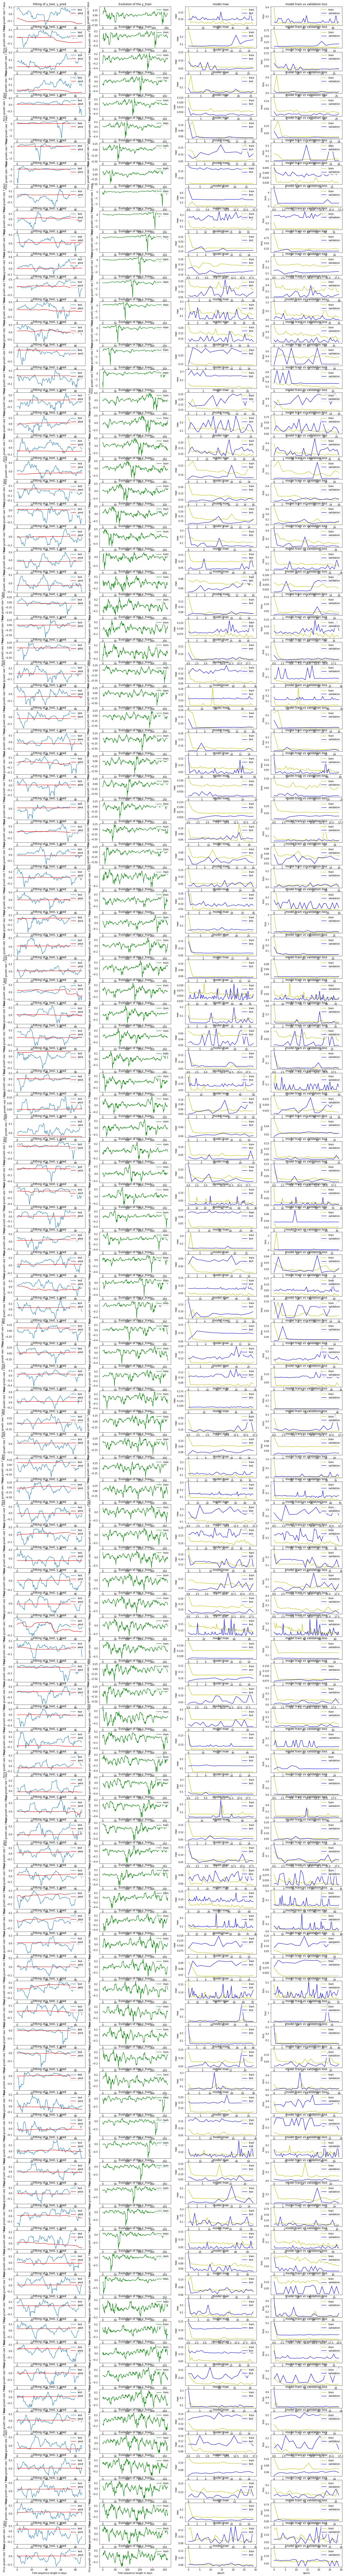

In [56]:
l1_rnn = 0.01653480436240602
l2_rnn = 0.0792386474

plot_predictions_models_all_folds(X_train_list, Y_train_list, X_test_list, Y_test_list, RnnDlModel_test(L1 = l1_rnn, L2 = l2_rnn, epochs = 250, patience = 15))



###### Exporting and viewing results

In [43]:
df_result = read_result()
df_result = df_result.sort_values(by="mean_score", ascending = True)
df_result

name                                         fold_score  mean_score  \
20  LinearReg  [0.06422, 0.08158, 0.10233, 0.10397, 0.0928, 0...     0.08007   
46        RNN  [0.08021, 0.07414, 0.15304, 0.09484, 0.09262, ...     0.08496   
45        RNN  [0.25442, 0.06626, 0.10818, 0.12145, 0.09141, ...     0.09662   
21      Dummy  [0.06752, 0.08603, 0.11788, 0.13216, 0.14218, ...     0.11057   
42        RNN  [0.14024, 0.06254, 0.10764, 0.08193, 0.24885, ...     0.13397   
10  LinearReg  [0.13612, 0.21353, 0.30214, 0.10699, 0.19859, ...     0.16727   
38  LinearReg  [0.13771, 0.21647, 0.30717, 0.10733, 0.20077, ...     0.16939   
25  LinearReg  [0.13809, 0.21718, 0.30844, 0.1074, 0.20131, 0...     0.16991   
17  LinearReg  [0.14206, 0.22432, 0.32162, 0.10804, 0.20692, ...     0.17525   
11  LinearReg  [0.14258, 0.22526, 0.32338, 0.10813, 0.20769, ...     0.17597   
14  LinearReg  [0.14356, 0.22703, 0.32675, 0.10832, 0.20915, ...     0.17733   
7   LinearReg  [0.14811, 0.23535, 0.34311, 0.10916, 0.21625, ...     0.18392   
22  LinearReg  [0.1485, 0.23608, 0.34458, 0.10923, 0.21689, 0...     0.18452   
18  LinearReg  [0.15123, 0.24124, 0.35522, 0.10981, 0.2216, 0...     0.18882   
6   LinearReg  [0.15154, 0.24184, 0.3565, 0.10987, 0.22217, 0...     0.18933   
4   LinearReg  [0.15219, 0.24308, 0.35915, 0.10999, 0.22336, ...     0.19040   
5   LinearReg  [0.15304, 0.24473, 0.36273, 0.11016, 0.225, 0....     0.19182   
35  LinearReg  [0.15322, 0.24509, 0.3635, 0.1102, 0.22536, 0....     0.19213   
16  LinearReg  [0.15433, 0.24688, 0.36744, 0.1104, 0.22718, 0...     0.19370   
36  LinearReg  [0.15546, 0.2487, 0.37153, 0.11062, 0.22909, 0...     0.19534   
15  LinearReg  [0.15629, 0.25013, 0.37476, 0.11079, 0.23062, ...     0.19664   
37  LinearReg  [0.15643, 0.25039, 0.37538, 0.11083, 0.23091, ...     0.19689   
33  LinearReg  [0.15746, 0.25253, 0.38032, 0.11109, 0.23331, ...     0.19889   
2   LinearReg  [0.15875, 0.25477, 0.38564, 0.11137, 0.23592, ...     0.20103   
12  LinearReg  [0.1602, 0.25723, 0.39163, 0.11171, 0.23892, 0...     0.20345   
31  LinearReg  [0.16138, 0.26, 0.39859, 0.11209, 0.24247, 0.3...     0.20624   
32  LinearReg  [0.1615, 0.26027, 0.39929, 0.11213, 0.24283, 0...     0.20652   
3   LinearReg  [0.16197, 0.26144, 0.40232, 0.11229, 0.24441, ...     0.20774   
0   LinearReg  [0.16269, 0.2633, 0.40722, 0.11255, 0.24699, 0...     0.20971   
23  LinearReg  [0.1644, 0.26967, 0.4212, 0.11325, 0.25466, 0....     0.21532   
26  LinearReg  [0.16589, 0.27603, 0.44034, 0.11413, 0.26599, ...     0.22293   
8   LinearReg  [0.1662, 0.28163, 0.45969, 0.11494, 0.27859, 0...     0.23059   
29  LinearReg  [0.16614, 0.28238, 0.46256, 0.11504, 0.28055, ...     0.23173   
13  LinearReg  [0.16549, 0.28577, 0.47637, 0.11552, 0.29048, ...     0.23723   
27  LinearReg  [0.16541, 0.28666, 0.48029, 0.11566, 0.29345, ...     0.23878   
30  LinearReg  [0.16178, 0.29209, 0.50732, 0.11644, 0.31503, ...     0.24929   
44        RNN  [0.0689, 0.07123, 0.11638, 0.20017, 0.19916, 0...     0.25531   
28  LinearReg  [0.15803, 0.29463, 0.52338, 0.11676, 0.33012, ...     0.25567   
1   LinearReg  [0.1574, 0.295, 0.5258, 0.11679, 0.33256, 0.41...     0.25665   
24  LinearReg  [0.14706, 0.29882, 0.55603, 0.11743, 0.3653, 0...     0.26908   
41  LinearReg  [0.13635, 0.30063, 0.58061, 0.1174, 0.39709, 0...     0.27974   
39  LinearReg  [0.13527, 0.30075, 0.58291, 0.11737, 0.40026, ...     0.28071   
34  LinearReg  [0.12487, 0.30148, 0.60465, 0.11738, 0.43215, ...     0.29027   
40  LinearReg  [0.12322, 0.30157, 0.60788, 0.11747, 0.43719, ...     0.29172   
9   LinearReg  [0.09834, 0.29143, 0.70277, 0.11837, 0.62478, ...     0.36053   
19  LinearReg  [0.1916, 0.28887, 0.79484, 0.24018, 0.55197, 0...     0.64564   
43        RNN  [0.13022, 0.13787, 0.33697, 0.17142, 0.09978, ...    16.67472   

    min_score  max_score                                        hyperparams  \
20    0.03786    0.11896                  {'alpha': 15, 'l1_ratio': 0.0001}   
46    0.04